# Deep learning Morpion Solitaire

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [1]:
from tqdm.notebook import trange
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image

In Google Colab, needs to upgrade `fastai` to newest version:

In [2]:
# !pip install --upgrade fastai

Load `fastai` library:

In [3]:
from fastai.vision.all import *
from fastai.callback.hook import *

/home/marc/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load data

Import data when running in Google Colab:

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# !ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [6]:
# !tar -xf 'gdrive/MyDrive/Colab Notebooks/data.tar.gz'
# !ls -l

Import the data:

In [25]:
path = Path('data/simple_data')
data_grids_open = np.load(path/'open.npy')
data_grids_closed = np.load(path/'closed.npy')
data_grids_open.shape, data_grids_closed.shape

((10000, 5, 18, 18), (10000, 5, 18, 18))

Visualization function for grid data:

In [26]:
def visualize(grid):
    size = 3 * grid.shape[2] - 2
    im = np.empty((size, size), dtype=bool)
    im[0::3,0::3] = grid[0,:,:]
    im[1::3,0::3] = grid[1,:-1,:]
    im[2::3,0::3] = grid[1,:-1,:]
    im[0::3,1::3] = grid[2,:,:-1]
    im[0::3,2::3] = grid[2,:,:-1]
    im[1::3,1::3] = grid[3,:-1,:-1]
    im[2::3,2::3] = grid[3,:-1,:-1]
    im[1::3,2::3] = grid[4,1:,:-1]
    im[2::3,1::3] = grid[4,1:,:-1]
    return Image.fromarray(~im)

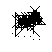

In [27]:
visualize(data_grids_open[0])

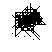

In [28]:
visualize(data_grids_closed[0])

Create a Pandas dataframe:

In [91]:
df_open = pd.DataFrame(zip(data_grids_open, np.ones(data_grids_open.shape[0])),
                       columns = ['grid', 'label'])
df_closed = pd.DataFrame(zip(data_grids_closed, np.zeros(data_grids_closed.shape[0])),
                         columns = ['grid', 'label'])
dataframe = pd.concat([df_open, df_closed])

In [87]:
# data_grids = np.concatenate((data_grids_open, data_grids_closed))
# labels = np.concatenate((np.ones(data_grids_open.shape[0]), np.zeros(data_grids_closed.shape[0])))
# dataframe = pd.DataFrame(zip(data_grids, labels),
#                          columns = ['grid', 'label'])

Shuffle the data:

In [95]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# DataLoaders

In [99]:
GRID_SIZE = 18

The `x` value is a grid of size `GRID_SIZE x GRID_SIZE`, with the actual grid loaded from the dataframe inserted at a random position:

In [150]:
def get_x(data): return torch.tensor(data['grid']).float()
def get_y(data): return torch.tensor([data['label']]).float()

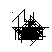

In [151]:
visualize(dataframe['grid'].iloc[0])

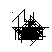

In [152]:
visualize(get_x(dataframe.iloc[0]))

In [153]:
dataframe['label'].iloc[0], get_y(dataframe.iloc[0])

(0.0, tensor([0.]))

DataBlock and DataLoaders:

In [154]:
dblock = DataBlock(get_x = get_x, get_y = get_y)

In [155]:
dls = dblock.dataloaders(dataframe, bs = 200)

Check one batch:

In [156]:
x_batch, y_batch = dls.one_batch()
x_batch.shape, y_batch.shape

(torch.Size([200, 5, 18, 18]), torch.Size([200, 1]))

In [157]:
y_batch.mean()

tensor(0.4600)

## Loss function and metrics

In [31]:
# def sigmoid(x): return 1/(1 + torch.exp(-x))

In [32]:
# def loss_fct(predictions, targets):
#     predictions = sigmoid(predictions)
#     return torch.where(targets == 1, 1 - predictions, predictions).mean()

In [158]:
def accuracy_fct(inputs, targets):
    return torch.where(inputs > 0.0, targets, 1 - targets).mean()

## Convolutional neural network

Define the network architecture:

In [159]:
net = nn.Sequential(
    nn.Conv2d(5, 20, stride = 1, kernel_size = 5, padding = 2),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    nn.Linear(20, 1),
    nn.ReLU(),
    nn.Linear(1, 1)
)

In [37]:
# net[0].weight.shape, net[0].bias.shape

In [38]:
# net[0].weight[0]

In [39]:
# net[4].weight.shape, net[4].bias.shape

In [160]:
with torch.no_grad():
    for i in range(20):
        net[0].bias[i] = -3
        net[0].weight[i] = torch.zeros(5,5,5)
    for c in range(5):
        net[0].weight[c,0,2] = torch.tensor([1,1,1,1,1])
        net[0].weight[c,2,2] = torch.tensor([-1,-1,-1,-1,0])
        net[0].weight[c,0,2,c] = -1
        net[0].weight[5+c,0,:,2] = torch.tensor([1,1,1,1,1])
        net[0].weight[5+c,1,:,2] = torch.tensor([-1,-1,-1,-1,0])
        net[0].weight[5+c,0,c,2] = -1
        for i in range(5):
            net[0].weight[10+c,0,i,i] = 1
        for i in range(4):
            net[0].weight[10+c,3,i,i] = -1
        net[0].weight[10+c,0,c,c] = -1
        for i in range(5):
            net[0].weight[15+c,0,i,4-i] = 1
        for i in range(1,5):
            net[0].weight[15+c,4,i,4-i] = -1
        net[0].weight[15+c,0,c,4-c] = -1
    net[4].weight[0] = torch.zeros(20) - 1
    net[4].bias[0] = 1
    net[6].weight[0] = -1
    net[6].bias[0] = 1

In [162]:
x_batch_pred = net(x_batch).data
x_batch_pred.mean(), x_batch_pred.std()

(tensor(0.4600), tensor(0.4996))

In [163]:
torch.stack((x_batch_pred, y_batch)).squeeze().T

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1

We get 100% accuracy with this simple model!

In [164]:
# loss_fct(x_batch_pred, y_batch)

In [165]:
accuracy_fct(x_batch_pred, y_batch)

tensor(1.)

In [34]:
# net = nn.Sequential(
#     nn.Conv2d(5, 64, stride = 1, kernel_size = 5, padding = 2),
#     nn.AdaptiveMaxPool2d(1),
#     Flatten(),
#     nn.Linear(64, 64),
#     nn.ReLU(),
#     nn.Linear(64, 1),
# )

In [35]:
# net = nn.Sequential(
#     nn.Conv2d(5, 30, stride = 1, kernel_size = 3, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(30, 60, stride = 1, kernel_size = 3, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(60, 120, stride = 1, kernel_size = 3, padding = 1),
#     nn.ReLU(),
#     nn.AdaptiveAvgPool2d(1),
#     Flatten(),
#     nn.Linear(120, 1),
# )

For a trainable model to reach the same result, one should probably have more parameters:

In [167]:
net = nn.Sequential(
    nn.Conv2d(5, 64, stride = 1, kernel_size = 5, padding = 2),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

Still, this does not seem to work... so let's try another model that seems more "trainable" (i.e. it does not require finding complicated patterns in the first layer):

In [172]:
net = nn.Sequential(
    # stem: use 3 layers with 3x3 kernel, and quite a few parameters
    nn.Conv2d(5, 32, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(32, 128, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(128, 512, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    # flattening
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    # another couple of linear layers to perform basic operations
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

## Training

In [173]:
learn = Learner(dls, net, loss_func = nn.BCEWithLogitsLoss(),
                #loss_func = nn.MSELoss(),
                metrics = accuracy_fct,
                cbs = ActivationStats(with_hist = True))

In [95]:
# learn.summary()

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=0.013182567432522774)

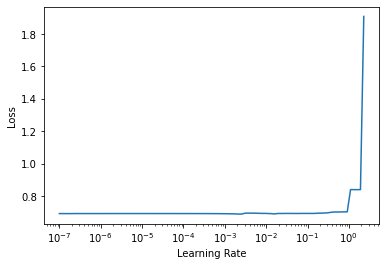

In [174]:
learn.lr_find()

In [176]:
learn.fit_one_cycle(10, lr_max = 1.0e-2)

epoch,train_loss,valid_loss,accuracy_fct,time
0,0.649412,0.612274,0.656500,03:32
1,0.623463,0.619536,0.671250,03:31
2,0.597636,0.564291,0.684000,03:26
3,0.536469,0.534466,0.709500,03:27
4,0.446171,0.419329,0.806500,03:27
5,0.344152,0.278483,0.882000,03:26
6,0.255832,0.223448,0.914250,03:28
7,0.199831,0.225180,0.914000,03:44
8,0.166875,0.211938,0.921000,03:40
9,0.149248,0.217293,0.918500,03:37


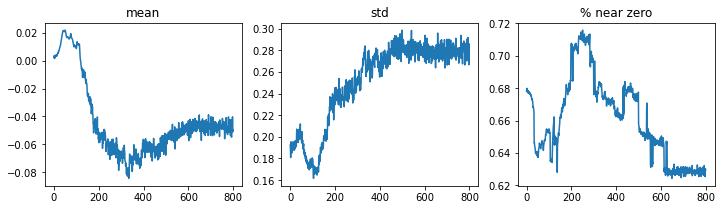

In [177]:
learn.activation_stats.plot_layer_stats(0)

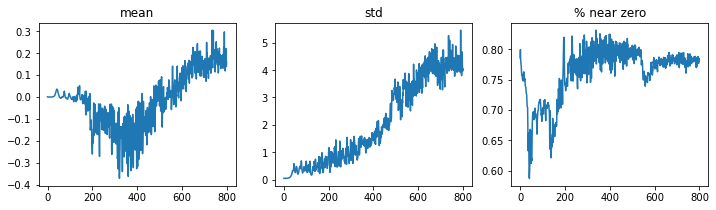

In [178]:
learn.activation_stats.plot_layer_stats(-2)

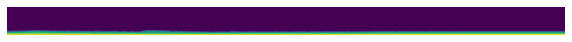

In [179]:
learn.activation_stats.color_dim(0)

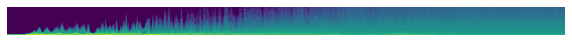

In [180]:
learn.activation_stats.color_dim(-2)

In [125]:
# learn.export(fname = 'models/cross_5T_0.pkl')

In [ ]:
# torch.save(net, 'models/test.pkl')

## Inference

In [181]:
x_valid, y_valid = dls.valid.one_batch()

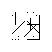

In [182]:
visualize(x_valid[0])

In [183]:
y_valid[0]

tensor([0.])

In [184]:
y_preds = net(x_valid).data

In [185]:
accuracy_fct(y_preds, y_valid)

tensor(0.9050)

In [186]:
y_preds.mean()

tensor(6.0471)

In [189]:
1/(1 + torch.exp(-y_preds))

tensor([[0.1385],
        [0.0995],
        [0.0159],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0584],
        [0.0397],
        [0.0421],
        [1.0000],
        [1.0000],
        [0.3881],
        [1.0000],
        [0.0303],
        [0.7005],
        [1.0000],
        [0.0170],
        [1.0000],
        [0.0350],
        [0.2142],
        [1.0000],
        [0.9992],
        [0.0940],
        [1.0000],
        [0.3870],
        [1.0000],
        [0.9288],
        [0.4025],
        [0.0599],
        [0.9992],
        [0.0869],
        [0.1312],
        [0.0173],
        [0.9333],
        [0.8743],
        [0.1254],
        [1.0000],
        [0.2174],
        [0.3170],
        [0.9015],
        [0.0767],
        [0.1552],
        [0.1088],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9989],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0895],
        [0.1021],
        [0.1756],
        [0.0169],
        [0.0917],
        [0

In [187]:
y_preds.std()

tensor(12.6473)

In [188]:
torch.stack((y_preds.squeeze(), y_valid.squeeze())).T

tensor([[-1.8278,  0.0000],
        [-2.2029,  0.0000],
        [-4.1257,  0.0000],
        [11.3169,  1.0000],
        [17.2497,  1.0000],
        [13.5975,  1.0000],
        [-2.7796,  0.0000],
        [-3.1855,  0.0000],
        [-3.1243,  0.0000],
        [17.7338,  1.0000],
        [18.0145,  1.0000],
        [-0.4554,  0.0000],
        [17.5152,  1.0000],
        [-3.4665,  0.0000],
        [ 0.8498,  1.0000],
        [42.7035,  1.0000],
        [-4.0595,  0.0000],
        [32.1728,  1.0000],
        [-3.3164,  0.0000],
        [-1.3001,  0.0000],
        [17.3616,  1.0000],
        [ 7.1617,  1.0000],
        [-2.2654,  0.0000],
        [27.0682,  1.0000],
        [-0.4599,  1.0000],
        [16.0702,  1.0000],
        [ 2.5683,  1.0000],
        [-0.3951,  0.0000],
        [-2.7538,  0.0000],
        [ 7.0824,  1.0000],
        [-2.3516,  1.0000],
        [-1.8907,  0.0000],
        [-4.0378,  0.0000],
        [ 2.6385,  1.0000],
        [ 1.9396,  0.0000],
        [-1.9425,  0